In [251]:
from tqdm import tqdm

from datasets.nuscenes import compile_data as compile_data_nuscenes
from tools.loss import *
import yaml
import seaborn as sns
from tools.utils import save_pred

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
from models.cvt.cross_view_transformer import *
torch.multiprocessing.set_sharing_strategy('file_system')


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [317]:
with open("./configs/train_nuscenes_cvt_baseline.yaml", 'r') as file:
    config = yaml.safe_load(file)
config['batch_size'] = 1
config['num_workers'] = 1

train_loader, val_loader = compile_data_nuscenes("mini", config, shuffle_train=True)

Flipped: False
Dims: (224, 480)
../data/nuscenes/mini
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (224, 480), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}
NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (224, 480), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}


In [ ]:
cvt = nn.DataParallel(CrossViewTransformer(outC=4), device_ids=[0])
cvt.load_state_dict(torch.load("./nuscenes/cvt_baseline_old/best_iou.pt"))    

In [334]:
t = iter(train_loader)
next(t)
next(t)
imgs, rots, trans, intrins, extrins, post_rots, post_trans, labels = next(t)
preds, atts = cvt(imgs, rots, trans, intrins, extrins, post_rots, post_trans, return_att=True)

In [335]:
hw = [
    (56, 120),
    (14, 30),
]
H, W = 25, 25

preds, atts = cvt(imgs, rots, trans, intrins, extrins, post_rots, post_trans, return_att=True)

rearranged_atts = []
for i, att in enumerate(atts):
    rearrangd_att = rearrange(att, '(b m) (H W) (n h w) -> b m H W n h w', n=6, m=4, H=H, W=W, h=hw[i][0],
                              w=hw[i][1])
    rearranged_atts.append(rearrangd_att)

# Visualization
att = rearranged_atts[-1]  # get the last attention layer
att = att[0].detach()  # batch size is 1, we remove the batch dim here.
mean_att = torch.mean(att, dim=0)
preds = preds.softmax(dim=1)
pred, labels = save_pred(preds, labels, './')


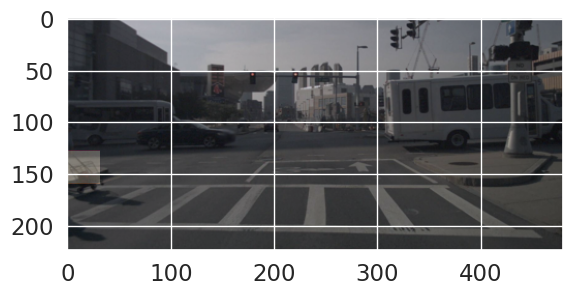

In [339]:
cid = 1
sx = 0
sy = 8
ex = 2
ey = 10
# cid = 1
# sx = 13
# sy = 6
# ex = 11
# ey = 7
cam_img = np.transpose(imgs[0][cid].cpu().numpy(), (1, 2, 0))
q = np.zeros(hw[1])
q[sy:ey, sx:ex] = 1
qr = cv2.resize(q, dsize=(480, 224),
                        interpolation=cv2.INTER_NEAREST)

plt.imshow(cam_img)
plt.imshow(qr, alpha=.25)

()
()
()
()


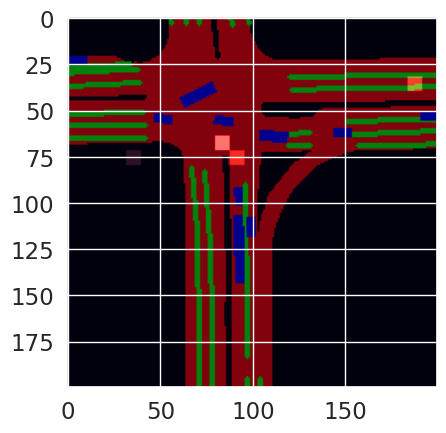

In [340]:
plt.imshow(labels/255)       
query_mask = np.zeros((H, W))


for x in range(sx, ex):
    for y in range(sy, ey):
        x,y,k = map(mean_att,cid,x,y)
#         print(x,y,k)
        print(k.shape)
#         query_mask += k
        query_mask[x,y] += k
query_result = cv2.resize(query_mask, dsize=(200, 200),
                        interpolation=cv2.INTER_NEAREST)
plt.imshow(query_result, alpha=.5)


In [228]:
def map (atts, cidx, x, y):
    atts = atts.cpu().numpy()

    max_x = 0
    max_y = 0
    max_att = 0

#     return atts[:,:,cidx,y,x]                         
    
    for mx in range(25):
        for my in range(25):
            am = atts[mx][my][cidx][y][x]

            if am > max_att:
                max_att = am
                max_x = mx
                max_y = my

    return max_x, max_y, max_att